In [ ]:

import sys
sys.path.append('../../')


from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.fftpack import fft
from scipy import stats # for zscoring

from sklearn.covariance import GraphicalLassoCV

from numpy.polynomial.polynomial import polyfit, polyval

import matplotlib.pyplot as plt

In [2]:
# load data
def loaddata(filename):
    data = loadmat(filename)
    bpchan = int(data['bpchan'][0][0])
    channels = data['channels'][0]
    conditionNames = data['conditionNames'][0]
    conditions = data['conditions'][0]
    eeg = dict()
    eeg[0] = data['dataL'][0]
    eeg[1] = data['dataR'][0]
    intervals = data['intervals'][0]
    labels = data['labels'][0]
    samples = data['samples'][0]
    session = int(data['session'][0])
    sessionTypes = data['sessionTypes'][0]
    sr = int(data['sr'][0])
    #Labels and condition names doesnt come over cleanly from matlab 
    chan_labels = list()
    condition_Names = list()
    #pythonify condition index
    condition_index = list()
    for j in range(len(labels)):
        chan_labels.append(labels[j][0])
    for j in range(len(conditionNames)):
        condition_Names.append(conditionNames[j][0])
    for j in range(12):
        condition_index.append(int(conditions[j]-1))
    return eeg, intervals, samples, condition_index, session, sr, bpchan, condition_Names, channels, chan_labels, sessionTypes 

In [3]:
def avref(datax):
	ref = np.mean(datax,axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	return datax

In [4]:
# build the narrow band filters
srnew = 200 
downsample = 10 
passbands = [[1,3],[3.5,6.5],[7,10],[10.5,13.5],[14 ,20],[21,29],[30,49.5]]
stopbands = [[0.75,3.25],[3.25,6.75],[6.75,10.25],[10.25,13.75],[13.75,20.5],[20.5,29.5],[29.5,50]]
bandlabels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)
    #plt.plot(w[1:500],20*np.log10(np.abs(h[1:500])))


In [5]:
# organize file in time sequence
filedir="../../"
pathname = 'Cleaned_data/'
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)

In [6]:
ncv = 5
pc_lasso = GraphicalLassoCV(cv=ncv)

In [10]:
filedates[9]
trial == 2
subject == 1 
frequency == 0

2022100401

In [21]:
amtest=np.array([1,2,3,4,5])

In [25]:
amtest[amtest>3]=3
amtest

array([1, 2, 3, 3, 3])

In [26]:
ampdata[ampdata>50]=50

In [29]:
pc_lasso.fit(ampdata)

/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bo

GraphicalLassoCV(alphas=4, assume_centered=False, cv=5, enet_tol=0.0001,
                 max_iter=100, mode='cd', n_jobs=None, n_refinements=4,
                 tol=0.0001, verbose=False)

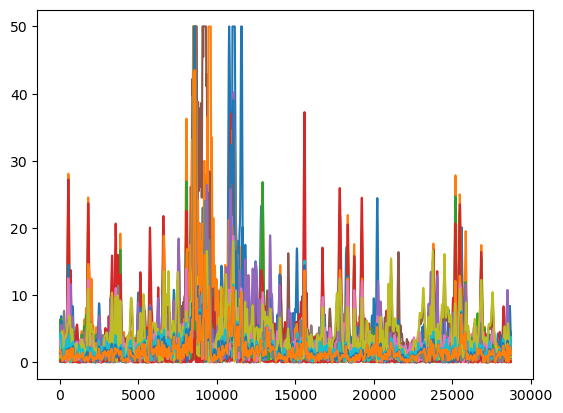

In [27]:
plt.plot(ampdata)

In [30]:
for ses in range(9,10):
    filename='clean_'+str(filedates[ses])+'.mat'
    [eeg, intervals, samples, condition_index, session, sr, bpchan, 
                condition_Names, channels, chan_labels, sessionTypes] \
                    = loaddata(filedir+pathname+filename)
    #make a low pass filter @ 50 Hz 
    sos_low, w,h = makefiltersos(sr,50,55)
    empirical_ampcorr = np.zeros((12,2,7,32,32))
    parcor = np.zeros((12,2,7,32,32))
    for trial in range(12):
        nsamp1 = np.shape(eeg[0][trial])[0]
        nsamp2 = np.shape(eeg[1][trial])[0]
        nsamp = np.min((nsamp1,nsamp2))
        for subject in range(2): 
            trialdata = avref(eeg[subject][trial][0:nsamp,0:32]) 
            trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
            trialdatanew = trialdata[range(0,nsamp,downsample),:]
            for frequency in range(7):
                        filtdata = sosfiltfilt(esos[frequency],trialdatanew,axis = 0,padtype ='odd')
                        hilbertdata = hilbert(filtdata,axis = 0)
                        ampdata=np.abs(hilbertdata)
                        empirical_ampcorr[trial,subject,frequency,:,:] = \
                            np.corrcoef(np.transpose(ampdata))
                        if ses == 9 and trial ==2 and subject == 1 and frequency == 0:
                            ampdata[ampdata>50]=50
                        pc_lasso.fit(ampdata)
                        precision = pc_lasso.precision_
                        y = np.diag(precision)
                        yy = np.outer(y,y)
                        yy = np.sqrt(yy)
                        parcor [trial,subject,frequency,:,:] \
                            = precision/yy

    outdict = dict()
    outdict['eeg_empirical_correlation'] = empirical_ampcorr
    outdict['eeg_partial_correlation'] = parcor

    outdict['new_sr'] = srnew
    outdict['passbands'] = passbands
    outdict['stopbands'] = stopbands
    outdict['band_labels'] = bandlabels
    outdict['filename'] = filename
    outdict['condition_index'] = condition_index
    outdict['condition_names'] = condition_Names
    outdict['channels'] = channels
    outdict['channel_labels'] = chan_labels
    outdict['intervals'] = intervals
    outdict['samples'] = samples
    outdict['sessionTypes'] = sessionTypes
    outdict['session'] = session*np.ones(12)
    savemat('Corr_eeg_200_'+str(filedates[ses]),outdict,store_python_metadata = True) 

/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bo